In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from itertools import product
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = 'NanumGothic'

In [3]:
df = pd.read_csv('df_fixed.csv')
df = df.drop(['Unnamed: 0', 'transacted_date', 'transacted_time', 'region', 'type_of_business'], axis=1)

In [4]:
df.isnull().sum()

store_id                  0
card_id                   0
card_company              0
installment_term          0
amount                    0
transacted_year           0
transacted_month          0
transacted_hour           0
type_big            3952609
region_big                0
region_detail             0
dtype: int64

In [5]:
df.head(3)

,store_id,card_id,card_company,installment_term,amount,transacted_year,transacted_month,transacted_hour,type_big,region_big,region_detail
0,0,0,b,0,1857.142857,2016,6,13,미용업,서울,광진구
1,0,1,h,0,857.142857,2016,6,18,미용업,서울,광진구
2,0,2,c,0,2000.000000,2016,6,18,미용업,서울,광진구


### check amount outliers

In [6]:
df[df['amount']>5000000]

,store_id,card_id,card_company,installment_term,amount,transacted_year,transacted_month,transacted_hour,type_big,region_big,region_detail
1483951,538,1024807,a,0,5.571429e+06,2017,4,17,도매업,서울,광진구
1485651,538,1024762,e,0,5.045518e+06,2018,4,9,도매업,서울,광진구


In [7]:
df = df.drop([1480622, 1482322])

In [8]:
# 1% 정도는 음수이다
len(df[df['amount']<0]), len(df[df['amount']<0])/len(df)

(73100, 0.01114905246018103)

In [9]:
df = df[df['amount']>0]

### check transacted

In [10]:
df['transacted_year'].min(), df['transacted_year'].max()

(2016, 2019)

In [11]:
df[df['transacted_year']==2016]['transacted_month'].min()
#2016년 6월부터 시작
#3, 4, 5 -> 1
#6, 7, 8 -> 2
#9, 10, 11 -> 3
#12, 1, 2 -> 4

6

In [12]:
df['date_block_num'] = (df['transacted_year'] - 2016) * 12 + df['transacted_month'] - 6

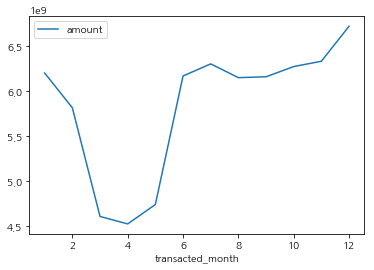

In [13]:
df.groupby('transacted_month').agg({'amount':'sum'}).plot()

### check installment

In [14]:
def check_point(val):
    if val>=60:
        return val-60
    return 0

In [15]:
def check_installment(val):
    if val<=60:
        return val
    return val-60

In [16]:
df['point_term'] = df['installment_term'].apply(check_point)

In [17]:
df['installment_term'] = df['installment_term'].apply(check_installment)

In [18]:
season_map = {3: 1, 4: 1, 5: 1,
             6: 2, 7: 2, 8: 2,
             9: 3, 10: 3, 11: 3,
             12: 4, 1: 4, 2: 4}
df['season_block'] = df['transacted_month'].replace(season_map)

In [19]:
df.head(3)

,store_id,card_id,card_company,installment_term,amount,transacted_year,transacted_month,transacted_hour,type_big,region_big,region_detail,date_block_num,point_term,season_block
0,0,0,b,0,1857.142857,2016,6,13,미용업,서울,광진구,0,0,2
1,0,1,h,0,857.142857,2016,6,18,미용업,서울,광진구,0,0,2
2,0,2,c,0,2000.000000,2016,6,18,미용업,서울,광진구,0,0,2


In [20]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=100, 
                  smoothing=10,
                  noise_level=0.01):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [21]:
ts = time.time()
matrix = []
cols = ['store_id', 'date_block_num']
for i in df['store_id'].unique():
    matrix.append(np.array(list(product(
                                        [i],
                                        df[df['store_id']==i]['date_block_num'].unique()
                                       )), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int16)
matrix['store_id'] = matrix['store_id'].astype(np.int16)
time.time() - ts

8.541361808776855

### check amount

In [22]:
group = df.groupby(['store_id','date_block_num', 'card_company'])['card_company'].size().unstack(fill_value=0).reset_index(False)
matrix = pd.merge(matrix, group, how='left', on=['store_id', 'date_block_num'])

In [23]:
group = df.groupby(['store_id', 'date_block_num', 'card_company']).agg({'amount':'sum'}).reset_index()
group.head(3)

,store_id,date_block_num,card_company,amount
0,0,0,a,236285.714286
1,0,0,b,150285.714286
2,0,0,c,168571.428571


In [24]:
for company in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']:
    group_tmp = group[group['card_company']==company][['store_id', 'date_block_num', 'amount']]
    group_tmp.columns = ['store_id', 'date_block_num', 'card_company_{}_avg'.format(company)]
    matrix = pd.merge(matrix, group_tmp, how='left', on=['store_id', 'date_block_num'])

In [25]:
group = df.groupby(['store_id', 'date_block_num']).agg({'installment_term':'sum'}).reset_index()
matrix = pd.merge(matrix, group, how='left', on=['store_id', 'date_block_num'])

group = df.groupby(['store_id', 'date_block_num']).agg({'point_term':'sum'}).reset_index()
matrix = pd.merge(matrix, group, how='left', on=['store_id', 'date_block_num'])

In [26]:
group = df[df['installment_term']>0].groupby(['store_id', 'date_block_num']).agg({'amount':'sum'})
group.columns = ['installment_term_total']
group = group.reset_index()
matrix = pd.merge(matrix, group, how='left', on=['store_id', 'date_block_num'])

group = df[df['point_term']>0].groupby(['store_id', 'date_block_num']).agg({'amount':'sum'})
group.columns = ['point_term_total']
group = group.reset_index()
matrix = pd.merge(matrix, group, how='left', on=['store_id', 'date_block_num'])
           

In [27]:
matrix['amount_month_sum'] = df.groupby(['store_id', 'date_block_num']).agg({'amount':'sum'}, as_index=False).values
#matrix['amount_month_mean'] = df.groupby(['store_id', 'date_block_num']).agg({'amount':'mean'}, as_index=False).values

In [28]:
def merge_matrix(key, target):
    group = df.groupby([key]).agg({target:pd.Series.unique}, as_index=True)
    group[key] = group.index
    return pd.merge(matrix, group, how='left', on=[key])

In [29]:
matrix = merge_matrix(key='store_id', target='type_big')

In [30]:
matrix = merge_matrix(key='date_block_num', target='season_block')

In [31]:
matrix = merge_matrix(key='date_block_num', target='transacted_year')

In [32]:
matrix = merge_matrix(key='date_block_num', target='transacted_month')

In [33]:
matrix = merge_matrix(key='store_id', target='region_big')

In [34]:
matrix = merge_matrix(key='store_id', target='region_detail')

In [35]:
matrix['type_big'].fillna('기타', inplace=True)

In [36]:
matrix.tail(3)

,store_id,date_block_num,a,b,c,d,e,f,g,h,...,point_term,installment_term_total,point_term_total,amount_month_sum,type_big,season_block,transacted_year,transacted_month,region_big,region_detail
60225,2136,30,108,49,56,128,27,22,6,4,...,0,NaN,NaN,2.452500e+06,주점업,4,2018,12,제주,제주시
60226,2136,31,78,50,30,98,15,15,9,1,...,0,9428.571429,NaN,1.879500e+06,주점업,4,2019,1,제주,제주시
60227,2136,32,102,68,39,109,29,12,10,2,...,0,NaN,NaN,2.266429e+06,주점업,4,2019,2,제주,제주시


In [37]:
for store_id in matrix['store_id'].unique():
    tmp_type = matrix[matrix['store_id']==store_id]['type_big'].unique()[0]
    tmp_region_big = matrix[matrix['store_id']==store_id]['region_big'].unique()[0]
    tmp_region_detail = matrix[matrix['store_id']==store_id]['region_detail'].unique()[0]
    
    for step, block in enumerate([33, 34, 35]):
        matrix = matrix.append(pd.DataFrame({'store_id': [store_id],
                                            'date_block_num': [block],
                                            'amount_month_sum': [np.nan],
                                            #'amount_month_mean': [np.nan],
                                            'type_big': [tmp_type],
                                            'season_block': [1],
                                            'transacted_year': [2019],
                                            'transacted_month': [step+3],
                                            'region_big': [tmp_region_big],
                                            'region_detail': [tmp_region_detail]}))
    

In [38]:
matrix.tail(3)

,a,amount_month_sum,b,c,card_company_a_avg,card_company_b_avg,card_company_c_avg,card_company_d_avg,card_company_e_avg,card_company_f_avg,...,installment_term_total,point_term,point_term_total,region_big,region_detail,season_block,store_id,transacted_month,transacted_year,type_big
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,제주,제주시,1,2136,3,2019,주점업
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,제주,제주시,1,2136,4,2019,주점업
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,제주,제주시,1,2136,5,2019,주점업


In [45]:
# Target with default parameters
import category_encoders as ce 
ce_target = ce.TargetEncoder(cols = ['region_big'])
ce_target.fit(matrix, matrix['amount_month_sum'])
matrix['encoding_region_big'] = ce_target.transform(matrix, matrix['amount_month_sum'])['region_big']

ce_target = ce.TargetEncoder(cols = ['region_detail'])
ce_target.fit(matrix, matrix['amount_month_sum'])
matrix['encoding_region_detail'] = ce_target.transform(matrix, matrix['amount_month_sum'])['region_detail']

ce_target = ce.TargetEncoder(cols = ['type_big'])
ce_target.fit(matrix, matrix['amount_month_sum'])
matrix['encoding_type_big'] = ce_target.transform(matrix, matrix['amount_month_sum'])['type_big']

In [ ]:
#matrix['encoding_region_big'], _ = target_encode(matrix['region_big'], matrix['region_big'], matrix['amount_month_sum'])
#matrix['encoding_region_detail'], _ = target_encode(matrix['region_detail'], matrix['region_detail'], matrix['amount_month_sum'])
#matrix['encoding_type_big'], _ = target_encode(matrix['type_big'], matrix['type_big'], matrix['amount_month_sum'])

In [ ]:
#matrix['amount_month_sum'] = np.log1p(matrix['amount_month_sum'])

In [ ]:
matrix.head(3)

In [46]:
for col in matrix.select_dtypes('float64').columns:
    if col != 'amount_month_sum':
        matrix[col] = matrix[col].astype(np.float32)
for col in ['date_block_num', 'season_block', 'store_id', 'transacted_month', 'transacted_year']:
    matrix[col] = matrix[col].astype(np.int16)

In [ ]:
matrix.head(3)

In [47]:
def lag_feature(data, lags, col):
    tmp = data[['date_block_num', 'store_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'store_id',
                          col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        data = pd.merge(data, shifted, on=['date_block_num', 'store_id'],
                          how='left')
    return data

In [48]:
lags_dist = [3, 4, 5, 6, 12, 13, 14, 24, 25]

In [49]:
#해당 타입의 월별 평균 매출
group = matrix.groupby(['date_block_num',
                        'type_big']).agg({'amount_month_sum': ['mean']})
group.columns = ['date_type_big_avg_amount']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num',
                        'type_big'], how='left')
matrix['date_type_big_avg_amount'] = matrix['date_type_big_avg_amount'].astype(np.float16)

matrix = lag_feature(matrix, lags_dist, 'date_type_big_avg_amount')
matrix.drop(['date_type_big_avg_amount'], axis=1, inplace=True)
print('finish')

finish


In [50]:
#해당 지역의 월별 평균 매출 1
group = matrix.groupby(['date_block_num',
                        'region_big']).agg({'amount_month_sum': ['mean']})
group.columns = ['date_region_big_avg_amount']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num',
                        'region_big'], how='left')
matrix['date_region_big_avg_amount'] = matrix['date_region_big_avg_amount'].astype(np.float16)
matrix = lag_feature(matrix, lags_dist, 'date_region_big_avg_amount')
matrix.drop(['date_region_big_avg_amount'], axis=1, inplace=True)
print('finish')

finish


In [51]:
 #해당 지역의 월별 평균 매출 2
group = matrix.groupby(['date_block_num',
                        'region_detail']).agg({'amount_month_sum': ['mean']})
group.columns = ['date_region_detail_avg_amount']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num',
                        'region_detail'], how='left')
matrix['date_region_detail_avg_amount'] = matrix['date_region_detail_avg_amount'].astype(np.float16)
matrix = lag_feature(matrix, lags_dist, 'date_region_detail_avg_amount')
matrix.drop(['date_region_detail_avg_amount'], axis=1, inplace=True)
print('finish')

finish


In [52]:
#가게의 평균 판매 금액에서 lag 달의 판매 %
group = matrix.groupby(['store_id']).agg({'amount_month_sum':['mean']})
group.columns = ['amount_avg_store_id']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['store_id'], how='left')
matrix['amount_avg_store_id'] = matrix['amount_avg_store_id'].astype(np.float32)

matrix['delta_amount_avg'] =( matrix['amount_month_sum'] - matrix['amount_avg_store_id']) / matrix['amount_avg_store_id']

matrix = matrix.drop(['amount_avg_store_id'], axis=1)

In [53]:
#이전 매출
lag_features = ['delta_amount_avg', 'amount_month_sum', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for feature in lag_features:
    matrix = lag_feature(data=matrix, lags=lags_dist, col=feature )

In [54]:
for company in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']:
    company = 'card_company_{}_avg'.format(company)
    matrix = lag_feature(data=matrix, lags=lags_dist, col=company)
    matrix = matrix.drop([company], axis=1)

In [55]:
for company in ['installment_term', 'point_term']:
    matrix = lag_feature(data=matrix, lags=lags_dist, col=company)
    matrix = matrix.drop([company], axis=1)

In [56]:
for company in ['installment_term_total', 'point_term_total']:
    matrix = lag_feature(data=matrix, lags=lags_dist, col=company)
    matrix = matrix.drop([company], axis=1)

In [57]:
matrix = matrix.drop(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'], axis=1)

In [58]:
matrix = matrix.drop(['delta_amount_avg'], axis=1)

In [59]:
matrix = pd.concat([matrix,pd.get_dummies(matrix['transacted_month'], prefix='transacted_month')],axis=1)

In [60]:
matrix.to_csv('matrix_ce_targetencoding.csv', index=False)

In [61]:
print('finish')

finish


Text(0, 0.5, 'Noisy target encoding')

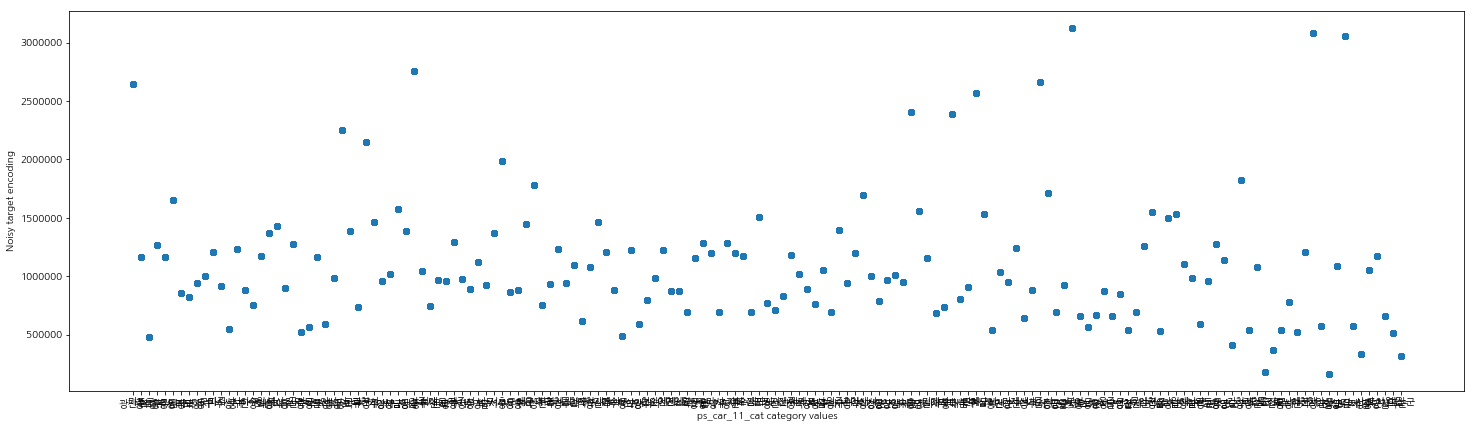

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(25,7))
plt.scatter(matrix['region_detail'], matrix['encoding_region_detail'])
plt.xlabel("ps_car_11_cat category values")
plt.ylabel("Noisy target encoding")

In [ ]:
pd.set_option('max_columns', None)
matrix.tail(3)